#### Simulation
>The purpose of this notebook is to explore simulation models with the simpy library. I am simulating a simplified airport security system at a busy airport. Passengers arrive according to a Poisson distribution with λ1 = 5 per minute (i.e., mean interarrival rate 1 = 0.2 minutes) to the ID/boarding-pass check queue, where there are several servers who each have exponential service time with mean rate 2 = 0.75 minutes. UI am going to build a simulation of the system, and then vary the number of ID/boarding-pass checkers and personal-check queues to determine how many are needed to keep average wait times below 15 minutes.

I am going to use the SimPy package in Python to create the simulation and determine the optimal number of ID/boarding-pass checkers and personal-check queues. I will also rerun it for a lambda of 50 to simulate a busier airport. To start, I am going to load the required libraries.

In [15]:
import simpy # for the simulation
import itertools # used for creating the passengers
import numpy as np # used for exponential, poisson, and uniform distributions
import matplotlib.pyplot as plt # used to visualize the results
import pandas as pd # used to display the results
from mpl_toolkits.mplot3d import Axes3D # used to visualize the results

Now that the libraries are loaded, the first step is to create the airport class and the ID check and personal scanner processes. The ID check and personal scanners are resources that I can vary the quantity of inside a loop. The amount of wait time for the ID check is modeled using an exponential distribution so I randomly generate a value for the delay for that process using an exponential distribution and the numpy package. The time for the scanner is a unifrom distribution and I also used the numpy package to randomly generate that time for each instance of someone going to the scanner.

In [16]:
# Create airport class that includes ID check and personal scanner
class Airport:
    # Define instance attributes for each airport object
    def __init__(self, env, num_ID, num_scanners):
        self.env = env # Set the environment for the object

        # Creat ID Check Station and a list of personal scanners
        # Personal scanners are individual resources to allow for queue's
        self.ID_check = simpy.Resource(env, num_ID)
        self.P_scanner = [simpy.Resource(env, 1) for _ in range(num_scanners)]

    # Define the ID check process
    def id_check(self, person):
        # Yield for the average ID service time of 0.75
        yield self.env.timeout(np.random.exponential(1/0.75)) 
        
    # Define the personal scanner process
    def p_scanner(self, person):
        yield self.env.timeout(np.random.uniform(low=0.5, high=1.0))

Next, I'm going to create the person process which essentially goes through each of the steps that the person takes when they arrive at the airport. When they first arrive they go to the ID_check and once their is a ID check station open they wait for an amount determined by the exponential distribution above. After that, they select the personal scanner line with the smallest queue, wait until the scanner is available, and then proceed through the scanner which takes anywhere from 30 seconds to 1 minute as determined above. I also captured the amount of time it took each person to get through the entire process so that the model could be evaluated and the optimal number of ID checkers and personal scanners could be determined.

In [28]:
# Create the person process
def person(env, name, airport):
    global average_time
    
    # Capture the arrival time for the person
    arrival_time = env.now

    # Start the ID Check process
    with airport.ID_check.request() as request:
        # Wait for an ID checker to become available
        yield request
        # Once it is available, proceed through the ID check process
        yield env.process(airport.id_check(name))

    # Get the time it took for the ID Check process
    ID_time = env.now - arrival_time

    # Capture the arrival time for the person to the scanner
    scanner_arrival = env.now
    
    # Determine which queue they will choose for the personal scanner
    min_queue = min(airport.P_scanner, key=lambda scanner: len(scanner.queue))
    min_queue_index = airport.P_scanner.index(min_queue)

    # Add person to the line and start the personal scan process
    with min_queue.request() as request:
        # Wait for the scanner to become available
        yield request
        # Once it is available, proceed through the personal scanner
        yield env.process(airport.p_scanner(name))
    
    # Add average wait time to the airports wait_times
    scanner_time = env.now - scanner_arrival
    total_time = env.now - arrival_time
    average_time.append((ID_time, scanner_time, total_time))

Next, I am going to create a setup process that essentially creates the airport and passengers I am simulating. Passengers arrive at the airport every minute and the number of passangers that arrive follows a poisson distribution.

In [53]:
# Create passanger arrival process
def setup(env, num_ID, num_scanners, arrival_time):
    # Create the airport
    airport = Airport(env, num_ID, num_scanners)

    # Create the passangers and send them to the airport!
    person_count = itertools.count()
    while True:
        yield env.timeout(np.random.poisson(lam=1/arrival_time))    
        env.process(person(env, f'Person {next(person_count)}', airport))

The last part of the setup was creating a function that ran the process. This allowed different numbers of ID checks and scanners to be passed into the function so that I can iterate over different combinations and determine the optimal solution.

In [54]:
# Create function for running with different ID check and Scanner counts
def simulate(env, num_ID, num_scanners, arrival_time, run_time):    
    env.process(setup(env, num_ID, num_scanners, arrival_time))
    env.run(until=run_time)

Now that everything is setup, I am going to iterate through different combinations of ID check and personal scanners to see what the smallest number is that can still keep wait times to be about 15 minutes (which is totally unrealistic for any airport I've ever been to!). I tried a few different values to get a general sense of the range that I want to use and for each combination I am running the simulation 100 times to account for the randomness in the model. I run each model for 720 minutes which is equivalent to 1 day, might be longer than needed but seems like a reasonable amount of time.

In [52]:
# Create a list of all of the possible combinations of ID checkers and scanners
combinations = list(itertools.product(range(2, 10), repeat = 2))

# Initialize a list for storing the average times for each combination
combo_wait_time = []

# Loop through each combination and store the average times
for num_ID, num_scanners in combinations:
    average_wait_time = []
    for i in range(100):
        env = simpy.Environment()
        average_time = []
        simulate(env, num_ID, num_scanners, 5, 1440)

        # Calculate average wait time for the run
        average_wait_time.append((np.mean([value[0] for value in average_time]),
                                  np.mean([value[1] for value in average_time]), 
                                  np.mean([value[2] for value in average_time])))
    
    combo_wait_time.append((np.mean([value[0] for value in average_wait_time]),
                            np.mean([value[1] for value in average_wait_time]), 
                            np.mean([value[2] for value in average_wait_time])))

Now that I have the results from each run, I want to visualize them. This is also just a great excuse to make a 3-D plot...

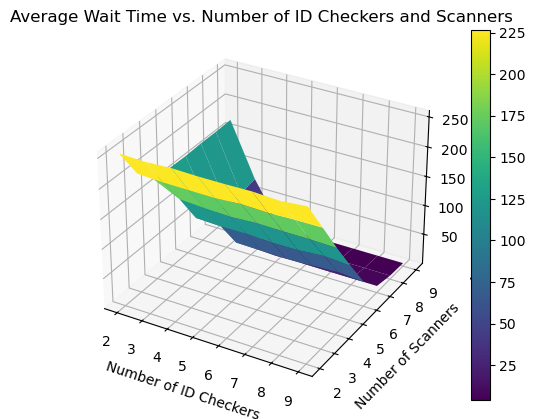

In [55]:
# Unpack the tuples to separate lists for ID_Checkers and P_Scanners
ID_Checkers = [pair[0] for pair in combinations]
P_Scanners = [pair[1] for pair in combinations]

ID_Checkers = np.array(ID_Checkers)
P_Scanners = np.array(P_Scanners)

# Create a meshgrid of ID_Checkers and P_Scanners
X, Y = np.meshgrid(np.unique(ID_Checkers), np.unique(P_Scanners))

# Reshape average_wait_times to match the shape of X and Y
Z = np.array([value[2] for value in combo_wait_time]).reshape(X.shape)

# Create a 3D surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# Set labels and title
ax.set_xlabel('Number of ID Checkers')
ax.set_ylabel('Number of Scanners')
ax.set_zlabel('Average Wait Time (minutes)')
ax.set_title('Average Wait Time vs. Number of ID Checkers and Scanners')

# Add a color bar
fig.colorbar(surf)

plt.show()

The last thing I want to do is look at the results in a table so I am going to create a dataframe to display the various times and combinations.

In [56]:
# Convert lists of tuples into DataFrames
combinations_df = pd.DataFrame(combinations, columns=['ID Stations',
                                                      'Personal Checkers'])
values_df = pd.DataFrame(combo_wait_time, columns=['ID Wait Time',
                                                   'Checker Wait Time',
                                                   'Total Time'])

# Concatenate the DataFrames horizontally
result_df = pd.concat([combinations_df, values_df], axis=1)

# Display the resulting DataFrame
result_df[result_df['Total Time'] < 60]

,ID Stations,Personal Checkers,ID Wait Time,Checker Wait Time,Total Time
34,6,4,41.205331,1.484734,42.690065
35,6,5,40.357183,1.201671,41.558853
36,6,6,39.541304,1.170473,40.711777
37,6,7,41.022191,1.166479,42.188669
38,6,8,43.102091,1.165750,44.267841
39,6,9,39.384836,1.166338,40.551174
42,7,4,9.467966,2.749969,12.217935
43,7,5,8.628505,1.276330,9.904835
44,7,6,9.385697,1.193135,10.578832
45,7,7,9.072329,1.180862,10.253191


Looking at the results, **having 7 ID stations and 4 personal checkers seems to be the best combination to keep the average wait time under 15 minutes.**

##### Large Aiport Simulation
The last thing I am going to do is change the average arrival time to 50 passangers per minute to simulate the larger airport environment. The process is similar to above so I'm not going to explain each step, the only thing that is changing is the lambda value in the setup function.

In [76]:
# Create a list of all of the possible combinations of ID checkers and scanners
combinations = list(itertools.product(range(35, 40), repeat = 2))
combinations = [(value[0]+35, value[1]) for value in combinations]

# Initialize a list for storing the average times for each combination
combo_wait_time = []

# Loop through each combination and store the average times
for num_ID, num_scanners in combinations:
    average_wait_time = []
    for i in range(100):
        env = simpy.Environment()
        average_time = []
        simulate(env, num_ID, num_scanners, 50, 1440) #updated lambda to 50

        # Calculate average wait time for the run
        average_wait_time.append((np.mean([value[0] for value in average_time]),
                                  np.mean([value[1] for value in average_time]), 
                                  np.mean([value[2] for value in average_time])))
    
    combo_wait_time.append((np.mean([value[0] for value in average_wait_time]),
                            np.mean([value[1] for value in average_wait_time]), 
                            np.mean([value[2] for value in average_wait_time])))

Just like before I want to visualize the results so I will output a 3D plot and dataframe below.

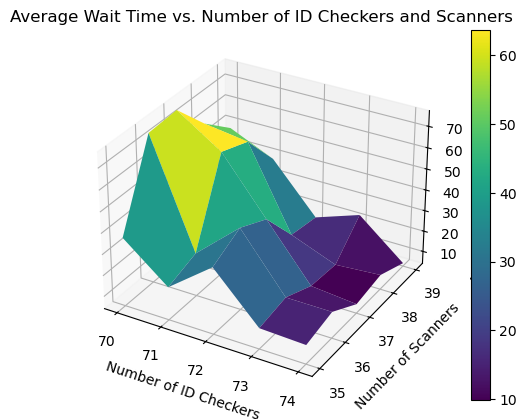

In [77]:
# Unpack the tuples to separate lists for ID_Checkers and P_Scanners
ID_Checkers = [pair[0] for pair in combinations]
P_Scanners = [pair[1] for pair in combinations]

ID_Checkers = np.array(ID_Checkers)
P_Scanners = np.array(P_Scanners)

# Create a meshgrid of ID_Checkers and P_Scanners
X, Y = np.meshgrid(np.unique(ID_Checkers), np.unique(P_Scanners))

# Reshape average_wait_times to match the shape of X and Y
Z = np.array([value[2] for value in combo_wait_time]).reshape(X.shape)

# Create a 3D surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# Set labels and title
ax.set_xlabel('Number of ID Checkers')
ax.set_ylabel('Number of Scanners')
ax.set_zlabel('Average Wait Time (minutes)')
ax.set_title('Average Wait Time vs. Number of ID Checkers and Scanners')

# Add a color bar
fig.colorbar(surf)

plt.show()

In [78]:
# Convert lists of tuples into DataFrames
combinations_df = pd.DataFrame(combinations, columns=['ID Stations',
                                                      'Personal Checkers'])
values_df = pd.DataFrame(combo_wait_time, columns=['ID Wait Time', 
                                                   'Checker Wait Time', 
                                                   'Total Time'])

# Concatenate the DataFrames horizontally
result_df = pd.concat([combinations_df, values_df], axis=1)

# Display the resulting DataFrame
result_df[result_df['Total Time'] < 30]

,ID Stations,Personal Checkers,ID Wait Time,Checker Wait Time,Total Time
1,70,36,6.656103,13.123145,19.779248
3,70,38,9.501840,4.522760,14.024599
4,70,39,9.058271,4.071390,13.129661
6,71,36,5.639184,18.927216,24.566399
8,71,38,7.398612,9.314069,16.712681
9,71,39,10.216258,6.434555,16.650813
13,72,38,5.368606,5.206243,10.574849
14,72,39,5.326985,3.168995,8.495980
17,73,37,6.165088,11.716476,17.881564
18,73,38,4.713988,4.828544,9.542532


Looking at the results above, **for a large airport having approximately 70 ID Stations and 38 Personal Scanners keeps wait time to ~15 minutes.**